<a href="https://colab.research.google.com/github/prashanth-acsq/Colab-Notebooks/blob/main/FDS_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Setup**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### **Library Imports**

In [2]:
import os
import re
import cv2
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Union, List

from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

### **Helpers**

In [3]:
SEED = 42
SIZE = 512


def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")

    
def get_image(path: str, size: int=224) -> np.ndarray:
    return cv2.resize(
        src=cv2.cvtColor(src=cv2.imread(path, cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB), 
        dsize=(size, size), 
        interpolation=cv2.INTER_AREA
    )

### **Configuration**

In [4]:
class CFG(object):
    def __init__(
            self, 
            seed: int = 42,
            size: int = 512,
            batch_size: int = 16,
        ):
        
        self.seed = seed
        self.size = size
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_transform = transforms.Compose([transforms.ToTensor(),
                                                   transforms.RandomAffine(degrees=(-45, 45), translate=(0.15, 0.15), scale=(0.5, 1.5), fill=0.5),
                                                   transforms.RandomHorizontalFlip(p=0.25),
                                                   transforms.RandomVerticalFlip(p=0.25),
                                                  ])
        self.valid_transform = transforms.Compose([transforms.ToTensor(), ])
    
cfg = CFG(seed=SEED, size=SIZE, batch_size=8)

### **Dataset Template**

In [5]:
class DS(Dataset):
    def __init__(self, base_path: str, size: int=224, filenames: Union[np.ndarray, List, None]=None, transform=None):
        self.base_path = base_path
        self.size = size
        self.filenames = filenames
        self.transform = transform
    
    def __len__(self):
        # return self.filenames.shape[0]
        return len(filenames)

    
    def __getitem__(self, idx):
        image = get_image(os.path.join(self.base_path, filenames[idx]), self.size)
        if self.transform is not None:
            return self.transform(image)
        else:
            return transforms.ToTensor()(image)

### **Model**

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.encoder = models.resnet18(weights="IMAGENET1K_V1")
        self.encoder = nn.Sequential(*[*self.encoder.children()][:-2])

        self.decoder = nn.Sequential()
        self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN1", nn.ReLU())
        self.decoder.add_module("UP1", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN2", nn.ReLU())
        self.decoder.add_module("UP2", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN3", nn.ReLU())
        self.decoder.add_module("UP3", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN4", nn.ReLU())
        self.decoder.add_module("UP4", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN5", nn.ReLU())
        self.decoder.add_module("UP5", nn.Upsample(scale_factor=2))
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

### **Predict Helper**

In [16]:
def predict_batch(
    model=None, 
    dataloader=None, 
    device=None, 
    in_channels: Union[int, None]=None, 
    size: Union[int, None]=None,
    path: Union[str, None]=None
) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, in_channels, size, size).to(device)
    
    for X in dataloader:
        X = X.to(device)
        with torch.no_grad():
            _, output = model(X)
        output = torch.sigmoid(output)
        y_pred = torch.cat((y_pred, output), dim=0)
    
    y_pred = y_pred[1:].detach().cpu().numpy()
    y_pred = np.clip(y_pred*255, 0, 255).astype("uint8")
    y_pred = y_pred.transpose(0, 2, 3, 1)
    return y_pred


def predict(
    model=None, 
    image=None, 
    device=None,
    size: Union[int, None]=None,
    path: Union[str, None]=None
) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()

    temp_image = image.copy()

    with torch.no_grad(): _, output = model(transforms.ToTensor()(image).to(device).unsqueeze(dim=0))
    recon_image = torch.sigmoid(output).squeeze().detach().cpu().numpy()
    recon_image = np.clip(recon_image*255, 0, 255).astype("uint8").transpose(1, 2, 0)
    
    return recon_image

### **Inference**

In [9]:
base_path: str = "/content/gdrive/My Drive/Datasets/fds"
filenames = sorted(os.listdir(base_path))

ts_data_setup = DS(base_path=base_path, filenames=filenames, size=cfg.size, transform=cfg.valid_transform)
ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

model = Model().to(cfg.device)

outputs = predict_batch(
    model=model, 
    dataloader=ts_data, 
    device=cfg.device, 
    in_channels=3, 
    size=cfg.size,
    path="/content/gdrive/MyDrive/Models/fds/r18-state-all.pt"
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

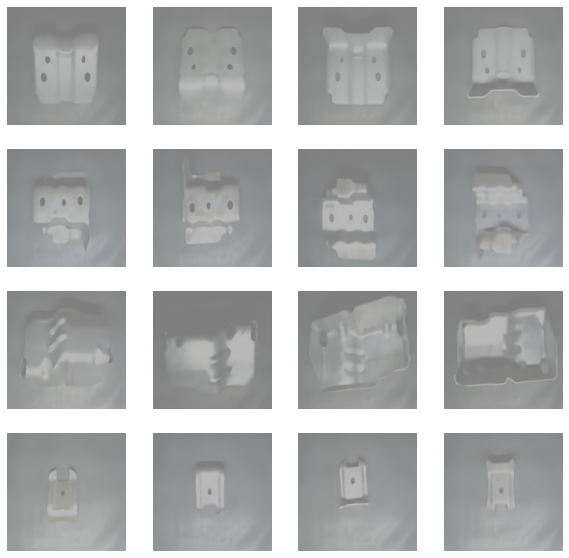

In [14]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(outputs[i])
    plt.axis("off")
plt.show()

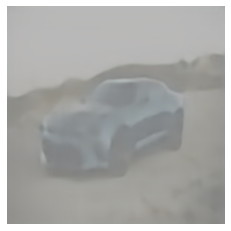

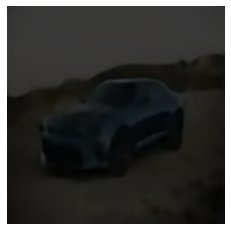

In [20]:
image = get_image("/content/Test_1.jpg", cfg.size)
model = Model().to(cfg.device)
recon_image = predict(model, image, cfg.device, cfg.size, "/content/gdrive/MyDrive/Models/fds/r18-state-all.pt")

plt.figure()
plt.imshow(recon_image)
plt.axis("off")
plt.show()
plt.figure()
plt.imshow(recon_image - 127)
plt.axis("off")
plt.show()